<a href="https://colab.research.google.com/github/heec12/SZ-detection/blob/main/FCN_SZ_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp28: 87.59


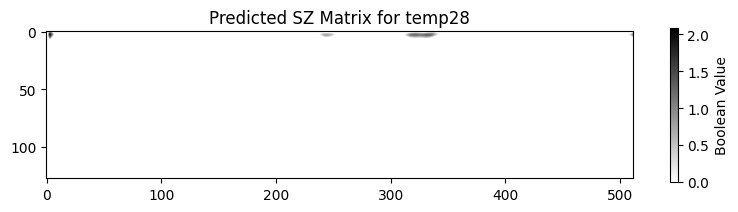

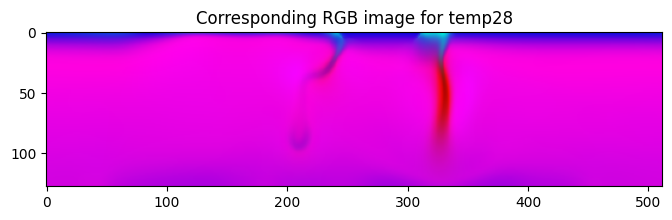

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp29: 136.24


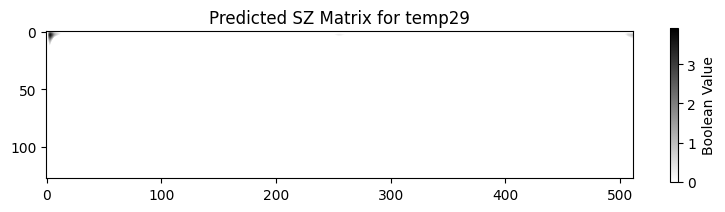

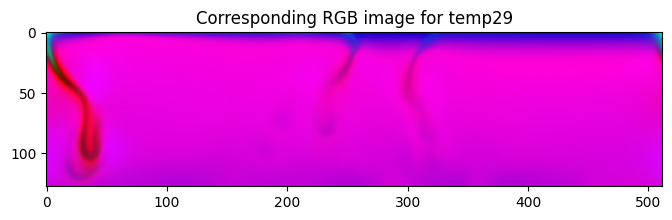

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp30: 82.14


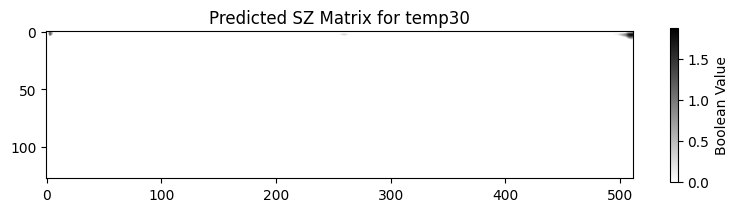

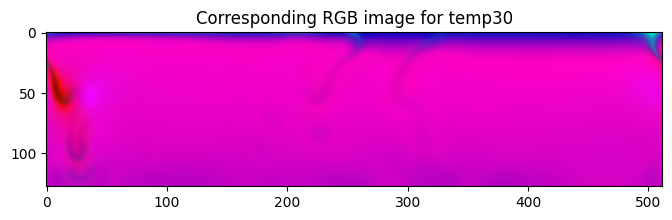

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp31: 90.48


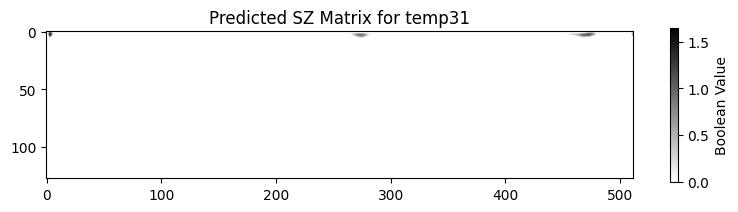

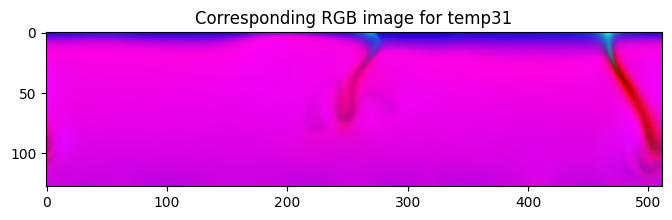

In [2]:

import torch
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# Define the FCN model
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x) # Make sure input 'x' has 3 channels
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        return x

# Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, device, epochs=12):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x = torch.tensor(X_train[i], device=device).float()
            y = y_train[i]
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
                                        # from torch.Size([1, 1, 128, 512])
                                        # to torch.Size([128, 512])
            loss = criterion(outputs, y) # Use binary cross entropy loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        #print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0 # Initialize total_loss here
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
                                        # from torch.Size([1, 1, 128, 512])
                                        # to torch.Size([128, 512])
            loss = criterion(outputs, y)
            total_loss += loss.item()

            # Visualize the output and target shapes
            print(f"Output shape: {outputs.shape}, Target Shape: {y.shape}")

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs
    # Return average loss instead of accuracy

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    #plt.imshow(y_matrix, cmap='binary')
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    #plt.xlabel('Width')
    #plt.ylabel('Height')
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    # Convert the tensor to a NumPy array
    np_array = loaded_tensor_rgb.cpu().numpy()
    # Plot the image
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the image using torch.load
#loaded_tensor = torch.load('/content/gdrive/MyDrive/rgbs/temp0.pt')
# Convert the tensor to correct shape
#reshaped_tensor=torch.permute(loaded_tensor, (2, 0, 1))
# Convert the tensor to float and scale to the range [0, 1]
#reshaped_tensor = reshaped_tensor.float() / 255.0
# Convert the tensor to a PIL image
#image = transforms.ToPILImage()(reshaped_tensor)


# Initialize model, criterion, optimizer
model = FCN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(30):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.LongTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].cpu().numpy().reshape(-1, 3, 128, 512)
    y_train = y_train_all[i]

    train_model(model, criterion, optimizer, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i+4}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    # Reshape to [batch_size, channels, height, width]
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.LongTensor)

    #accuracy = evaluate_model(model, criterion, X_eval, y_eval, device)
    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    print(f"Average loss for {input_temp1}: {average_loss:.2f}")

    ## Assuming y_eval is a boolean matrix of size [128, 512], reshape it accordingly
    #y_matrix = y_eval.cpu().numpy().reshape(128, 512)
    #plot_results(y_matrix, f'Predicted SZ Matrix for {input_temp1}')
    #plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


In [3]:
import torch
import torch.nn as nn
from google.colab import drive
drive.mount('/content/gdrive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_temp1 = 'temp' + str(0)
filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
loaded_tensor_bool = torch.load(filename_bool).to(device)
loaded_tensor_bool2long = loaded_tensor_bool.type(torch.LongTensor)

print(loaded_tensor_bool)
print(loaded_tensor_bool2long)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
